In [1]:
# compare the two find_subpixel_positions, from 
# windef and pyprocess

In [24]:
from openpiv import pyprocess
def find_subpixel_peak_position1(corr, subpixel_method='gaussian'):
        """
        Find subpixel approximation of the correlation peak.

        This function returns a subpixels approximation of the correlation
        peak by using one of the several methods available. If requested,
        the function also returns the signal to noise ratio level evaluated
        from the correlation map.

        Parameters
        ----------
        corr : np.ndarray
            the correlation map.

        subpixel_method : string
             one of the following methods to estimate subpixel location of the peak:
             'centroid' [replaces default if correlation map is negative],
             'gaussian' [default if correlation map is positive],
             'parabolic'.

        Returns
        -------
        subp_peak_position : two elements tuple
            the fractional row and column indices for the sub-pixel
            approximation of the correlation peak.
        """

        # initialization
        default_peak_position = (
                np.floor(corr.shape[0] / 2.), np.floor(corr.shape[1] / 2.))
        '''this calculates the default peak position (peak of the autocorrelation).
        It is window_size/2. It needs to be subtracted to from the peak found to determin the displacment
        '''
        #default_peak_position = (0,0)

        # the peak locations
        (peak1_i, peak1_j), dummy = pyprocess.find_first_peak(corr)
        '''
        The find_first_peak function returns the coordinates of the correlation peak
        and the value of the peak. Here only the coordinates are needed.
        '''

        try:
            # the peak and its neighbours: left, right, down, up
            c = corr[peak1_i,   peak1_j]
            cl = corr[peak1_i - 1, peak1_j]
            cr = corr[peak1_i + 1, peak1_j]
            cd = corr[peak1_i,   peak1_j - 1]
            cu = corr[peak1_i,   peak1_j + 1]

            # gaussian fit
            if np.any(np.array([c, cl, cr, cd, cu]) < 0) and subpixel_method == 'gaussian':
                subpixel_method = 'centroid'

            try:
                if subpixel_method == 'centroid':
                    subp_peak_position = (((peak1_i - 1) * cl + peak1_i * c + (peak1_i + 1) * cr) / (cl + c + cr),
                                          ((peak1_j - 1) * cd + peak1_j * c + (peak1_j + 1) * cu) / (cd + c + cu))

                elif subpixel_method == 'gaussian':
                    subp_peak_position = (peak1_i + ((np.log(cl) - np.log(cr)) / (2 * np.log(cl) - 4 * np.log(c) + 2 * np.log(cr))),
                                          peak1_j + ((np.log(cd) - np.log(cu)) / (2 * np.log(cd) - 4 * np.log(c) + 2 * np.log(cu))))

                elif subpixel_method == 'parabolic':
                    subp_peak_position = (peak1_i + (cl - cr) / (2 * cl - 4 * c + 2 * cr),
                                          peak1_j + (cd - cu) / (2 * cd - 4 * c + 2 * cu))

            except:
                subp_peak_position = default_peak_position

        except IndexError:
            subp_peak_position = default_peak_position

            '''This block is looking for the neighbouring pixels. The subpixelposition is calculated based one
            the correlation values. Different methods can be choosen.
            %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            This function returns the displacement in u and v
            '''
        return subp_peak_position[0] - default_peak_position[0], subp_peak_position[1] - default_peak_position[1]
    

In [25]:

def find_subpixel_peak_position2(corr, subpixel_method="gaussian"):
    """
    Find subpixel approximation of the correlation peak.

    This function returns a subpixels approximation of the correlation
    peak by using one of the several methods available. If requested,
    the function also returns the signal to noise ratio level evaluated
    from the correlation map.

    Parameters
    ----------
    corr : np.ndarray
        the correlation map.

    subpixel_method : string
         one of the following methods to estimate subpixel location of the
         peak:
         'centroid' [replaces default if correlation map is negative],
         'gaussian' [default if correlation map is positive],
         'parabolic'.

    Returns
    -------
    subp_peak_position : two elements tuple
        the fractional row and column indices for the sub-pixel
        approximation of the correlation peak.
    """

    # initialization
    # default_peak_position = (np.floor(corr.shape[0] / 2.),
    # np.floor(corr.shape[1] / 2.))
    # default_peak_position = np.array([0,0])
    eps = 1e-7
    subp_peak_position = (0.0, 0.0)

    # check inputs
    if subpixel_method not in ("gaussian", "centroid", "parabolic"):
        raise ValueError(f"Method not implemented {subpixel_method}")

    # the peak locations
    (peak1_i, peak1_j), _ = find_first_peak(corr)

    # import pdb; pdb.set_trace()

    # the peak and its neighbours: left, right, down, up
    # but we have to make sure that peak is not at the border
    # @ErichZimmer noticed this bug for the small windows

    if ((peak1_i == 0) | (peak1_i == corr.shape[0]-1) |
       (peak1_j == 0) | (peak1_j == corr.shape[1]-1)):
        return subp_peak_position
    else:
        corr += eps  # prevents log(0) = nan if "gaussian" is used (notebook)
        c = corr[peak1_i, peak1_j]
        cl = corr[peak1_i - 1, peak1_j]
        cr = corr[peak1_i + 1, peak1_j]
        cd = corr[peak1_i, peak1_j - 1]
        cu = corr[peak1_i, peak1_j + 1]

        # gaussian fit
        if np.logical_and(np.any(np.array([c, cl, cr, cd, cu]) < 0),
                          subpixel_method == "gaussian"):
            subpixel_method = "parabolic"

        # try:
        if subpixel_method == "centroid":
            subp_peak_position = (
                ((peak1_i - 1) * cl + peak1_i * c + (peak1_i + 1) * cr) /
                (cl + c + cr),
                ((peak1_j - 1) * cd + peak1_j * c + (peak1_j + 1) * cu) /
                (cd + c + cu),
            )

        elif subpixel_method == "gaussian":
            subp_peak_position = (
                peak1_i + ((log(cl) - log(cr)) / (2 * log(cl) - 4 * log(c) +
                           2 * log(cr))),
                peak1_j + ((log(cd) - log(cu)) / (2 * log(cd) - 4 * log(c) +
                           2 * log(cu))),
            )

        elif subpixel_method == "parabolic":
            subp_peak_position = (
                peak1_i + (cl - cr) / (2 * cl - 4 * c + 2 * cr),
                peak1_j + (cd - cu) / (2 * cd - 4 * c + 2 * cu),
            )

    #     except BaseException:
    #         subp_peak_position = default_peak_position

    #     except IndexError:
    #         subp_peak_position = default_peak_position

        return subp_peak_position


In [26]:
from openpiv.tools import imread
from openpiv.pyprocess import fft_correlate_strided_images
from pylab import *

In [27]:
a = imread('../data/PIVChallenge2001_A/A001_1.tif')
b = imread('../data/PIVChallenge2001_A/A001_2.tif')

In [28]:
a = a[:32,:32]
b = b[:32,:32]

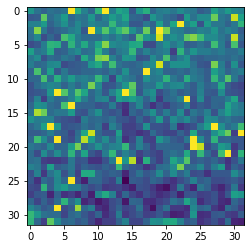

In [29]:
imshow(a)

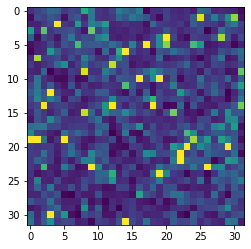

In [30]:
imshow(b)

In [31]:
a = a[np.newaxis,:,:]

In [32]:
b = b[np.newaxis,:,:]

In [33]:
a

array([[[166, 139, 128, ..., 170, 155, 151],
        [120, 124, 209, ..., 135, 240, 174],
        [151, 151, 170, ..., 128, 143, 190],
        ...,
        [155, 139, 120, ..., 135, 124, 104],
        [193, 166, 139, ..., 104, 100, 124],
        [190, 131, 104, ..., 135,  89,  85]]], dtype=uint8)

In [34]:
corr = fft_correlate_strided_images(a,b)

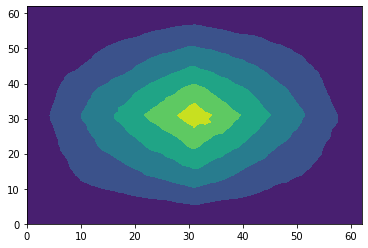

In [35]:
contourf(corr[0,:,:])

In [41]:
from openpiv import pyprocess
find_subpixel_peak_position1(corr[0,:,:])

(0.0020018365363085877, 0.04814832804507674)

In [43]:
from openpiv.pyprocess import find_first_peak
find_subpixel_peak_position2(corr[0,:,:])

(31.002001836536294, 31.04814832804508)

In [46]:
corr_shape = np.array(corr[0,:,:].shape)
default_peak_position = np.floor(corr_shape / 2.)

In [47]:
default_peak_position

array([31., 31.])

In [48]:
disp = find_subpixel_peak_position2(corr[0,:,:])

In [49]:
disp

(31.002001836536294, 31.04814832804508)

In [50]:
disp -= default_peak_position

In [51]:
disp

array([0.00200184, 0.04814833])